In [1]:
import os
os.chdir("../")
os.environ["OMP_NUM_THREADS"] = "11"

In [2]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
COLORS = list(TABLEAU_COLORS.values())

In [3]:
from scipy.optimize import linear_sum_assignment as LSA
from sklearn.cluster import KMeans, BisectingKMeans, DBSCAN
from sklearn.mixture import GaussianMixture as GMM
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, accuracy_score

In [4]:
from scripts.data.load import load_cora

## Data Loading

In [5]:
ids, one_hot_vectors, target, edges = load_cora()

In [6]:
id_idx_map = {_id: i for i, _id in enumerate(ids)}
adjacency = np.zeros((len(ids),len(ids)))
for u, v in edges: # u is cited by v
    u_idx = id_idx_map[u]
    v_idx = id_idx_map[v]
    adjacency[u_idx, v_idx] = 1

## Data Exploration

### Cyclical Citations

In [7]:
import networkx as nx
g = nx.from_edgelist(edges, create_using=nx.DiGraph)
cycles = list(nx.simple_cycles(g))
print(f"Number of cycles: {len(cycles)}")
cycles[1]

Number of cycles: 220


[648112, 648106]

### Class Distribution

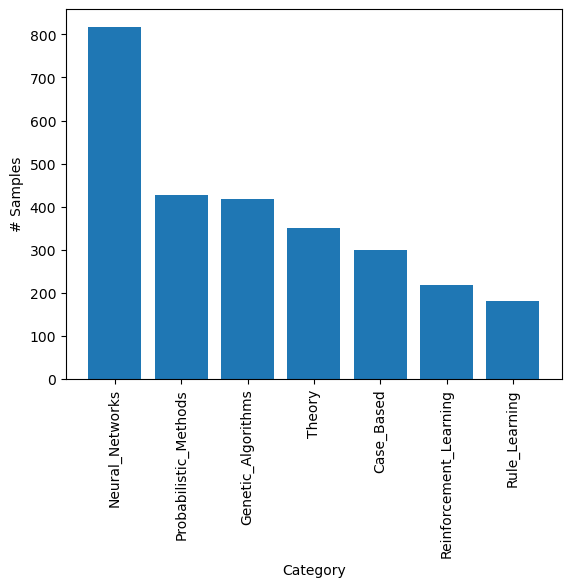

In [8]:
counts = defaultdict(int)
for c in target: counts[c]+=1
l, c = zip(*sorted(list(counts.items()), key=lambda x:x[1], reverse=True))
plt.bar(l, height=c)
plt.xticks(rotation=90)
plt.ylabel("# Samples")
plt.xlabel("Category")
plt.show()

### Citation Nepotism

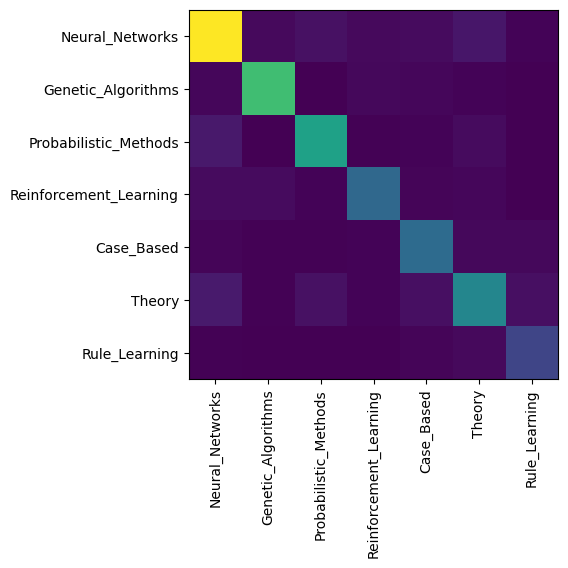

In [9]:
citation_matrix = defaultdict(lambda: defaultdict(int))
for i, row in enumerate(adjacency):
    for j, a in enumerate(row):
        if a: citation_matrix[target[i]][target[j]] += 1
cats = list(set(target))
n = len(cats)
cite_cat_matrix = np.zeros((n,n))
for i, c1 in enumerate(cats):
    for c2, cnt in citation_matrix[c1].items():
        j = cats.index(c2)
        cite_cat_matrix[i,j] = cnt
plt.imshow(cite_cat_matrix)
plt.xticks(ticks = range(7), labels=cats, rotation=90)
plt.yticks(ticks = range(7), labels=cats)
plt.show()

## Utility Functions

In [10]:
def visualize_encoding_spread(X, Y):
    x,y = TSNE(init='random', learning_rate='auto').fit_transform(X).T
    
    label_idxs = {l:i for i,l in enumerate(set(Y))}
    label_idxs = [label_idxs[l] for l in Y]
    c = [COLORS[i%len(COLORS)] for i in label_idxs]
    plt.scatter(x,y,c=c,marker=".")

In [11]:
def match_labels(y_actual, y_pred):
    actual_labels = list(set(y_actual))
    pred_labels = list(set(y_pred))
    
    
    actual_groups = defaultdict(set)
    pred_groups = defaultdict(set)
    
    for i, actual in enumerate(y_actual):
        actual_groups[actual].add(i)
    for i, pred in enumerate(y_pred):
        pred_groups[pred].add(i)
        
    N = len(actual_labels)
    M = len(pred_labels)
    cost_matrix = np.zeros((N,M))
    for i, label in enumerate(actual_labels):
        for j, pred in enumerate(pred_labels):
            cost_matrix[i, j] = len(actual_groups[label] - pred_groups[pred])
    
    conversion_map = {
        pred_labels[j]:actual_labels[i] 
        for i,j in zip(
            *LSA(
                cost_matrix,
            )
        )
    }
    return [conversion_map[p] if p in conversion_map else "N/A" for p in y_pred]

In [12]:
def evaluate(model, X):
    y_pred = model.fit_predict(X)
    acc = round(accuracy_score(target, match_labels(target, y_pred)), 2)
    nmi = round(normalized_mutual_info_score(target, y_pred),2)
    ars = round(adjusted_rand_score(target, y_pred),2)
    print(f"acc: {acc}  nmi: {nmi} ars: {ars}")

In [13]:
def normalize(X):
    d = ((X**2).sum(axis=1)**0.5)
    d[d==0]=1
    return (X.T / d).T

## Feature Engineering

In [14]:
def diffuse(X, adjacency_matrix, m=0.5):
    """
    The vectors returned from this function are intended to supplement
    the original vectors `X` with information about the paper's references.
    """
    X_prime = X.copy() * 0
    A = adjacency_matrix.astype(np.bool_)
    roots = list(np.where(A.sum(axis=0) == 0)[0])
    seen = set()
    N = A.sum(axis=0)
    while len(roots):
        i = roots.pop(0)
        children = set(np.where(A[i])[0])
        parents = set(np.where(A[:, i])[0])
        if i in seen:
            pass
        else:
            seen.add(i)
            roots += list(children.union(parents) - seen)
            for j in np.where(A[i])[0]:
                X_prime[j] += (X_prime[i] + X[i]) * (m / N[j])
    return normalize(X_prime)

## Evaluation

#### One-Hot Vectors

In [15]:
X_pca = PCA(
    n_components=128, 
    random_state=5
).fit_transform(
    one_hot_vectors
)

In [16]:
model = GMM(
    n_components=7,
    tol=0.01, 
    reg_covar=0.01,
    random_state=1
)
evaluate(model, X_pca)

acc: 0.34  nmi: 0.15 ars: 0.1


### Normalized Vectors

In [17]:
X_norm = normalize(X_pca)

In [18]:
model = GMM(
    n_components=7,
    tol=0.01, 
    reg_covar=0.01,
    random_state=3
)
evaluate(model, X_norm)

acc: 0.48  nmi: 0.25 ars: 0.23


### Reference Diffusion

In [19]:
X_ref = diffuse(X_norm, adjacency, 0.9)
X = normalize(X_norm + X_ref)

In [20]:
model = GMM(
    n_components=7,
    tol=0.01, 
    reg_covar=0.01,
    random_state=1
)
y_pred = model.fit_predict(X)
evaluate(model, X)

acc: 0.69  nmi: 0.5 ars: 0.44


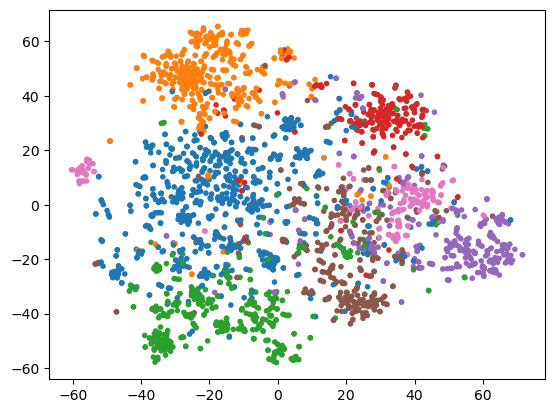

In [21]:
visualize_encoding_spread(X, target)